# FloPy

## MODFLOW-USG $-$ Discontinuous water table configuration over a stairway impervious base

One of the most challenging numerical cases for MODFLOW arises from drying-rewetting problems often associated with abrupt changes in the elevations of impervious base of a thin unconfined aquifer. This problem simulates a discontinuous water table configuration over a stairway impervious base and flow between constant-head boundaries in column 1 and 200. This problem is based on 

[Zaidel, J. (2013), Discontinuous Steady-State Analytical Solutions of the Boussinesq Equation and Their Numerical Representation by Modflow. Groundwater, 51: 952–959. doi: 10.1111/gwat.12019](http://onlinelibrary.wiley.com/doi/10.1111/gwat.12019/abstract)

The model consistes of a grid of 200 columns, 1 row, and 1 layer; a bottom altitude of ranging from 20 to 0 m; constant heads of 23 and 5 m in column 1 and 200, respectively; and a horizontal hydraulic conductivity of $1x10^{-4}$ m/d.  The discretization is 5 m in the row direction for all cells.

In this example results from MODFLOW-USG will be evaluated.

In [1]:
%matplotlib inline
import sys
import os
import platform
import numpy as np
import matplotlib.pyplot as plt

import flopy
import flopy.utils as fputl

#Set name of MODFLOW exe
#  assumes executable is in users path statement
exe_name = 'mfusg'
if platform.system() == 'Windows':
    exe_name = 'mfusg.exe'
mfexe = exe_name

modelpth = os.path.join('data')
modelname = 'zaidel'

#make sure modelpth directory exists
if not os.path.exists(modelpth):
    os.makedirs(modelpth)

## Model parameters

In [2]:
# model dimensions
nlay, nrow, ncol = 1, 1, 200
delr = 50.
delc = 1.

# boundary heads
h1 = 23.
h2 = 5.

# cell centroid locations
x = np.arange(0., float(ncol)*delr, delr) + delr / 2.

# ibound
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1

# bottom of the model
botm = 25 * np.ones((nlay + 1, nrow, ncol), dtype=np.float)
base = 20.
for j in range(ncol):
    botm[1, :, j] = base
    #if j > 0 and j % 40 == 0:
    if j+1 in [40,80,120,160]:
        base -= 5

# starting heads
strt = h1 * np.ones((nlay, nrow, ncol), dtype=np.float)
strt[:, :, -1] = h2

## Create and run the MODFLOW-USG model

In [3]:
#make the flopy model
mf = flopy.modflow.Modflow(modelname=modelname, exe_name=mfexe, model_ws=modelpth)
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol,
                               delr=delr, delc=delc, 
                               top=botm[0, :, :], botm=botm[1:, :, :], 
                               perlen=1, nstp=1, steady=True)
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(mf, hk=0.0001, laytyp=4)
oc = flopy.modflow.ModflowOc(mf, 
                             stress_period_data={(0,0): ['print budget', 'print head', 
                                                         'save head', 'save budget']})
sms = flopy.modflow.ModflowSms(mf, nonlinmeth=1, linmeth=1,
                               numtrack=50, btol=1.1, breduc=0.70, reslim = 0.0,
                               theta=0.85, akappa=0.0001, gamma=0., amomentum=0.1,
                               iacl=2, norder=0, level=5, north=7, iredsys=0, rrctol=0.,
                               idroptol=1, epsrn=1.e-5,
                               mxiter=500, hclose=1.e-3, hiclose=1.e-3, iter1=50)
mf.write_input()

# remove any existing head files
try:
    os.remove(os.path.join(model_ws, '{0}.hds'.format(modelname)))
except:
    pass

# run the model
mf.run_model()

FloPy is using the following executable to run the model: /Users/jdhughes/Documents/Development/bin/mac/mfusg

                                  MODFLOW-USG      
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER FLOW MODEL
                             Version 1.3.00 12/01/2015                       

 Using NAME file: zaidel.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2016/02/06 12:39:11

 Solving:  Stress period:     1    Time step:     1    Groundwater Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2016/02/06 12:39:11
 Elapsed run time:  0.013 Seconds

  Normal termination of simulation


(True, [])

### Read the simulated MODFLOW-USG model results

In [4]:
# Create the mfusg headfile object
headfile = os.path.join(modelpth, '{0}.hds'.format(modelname))
headobj = fputl.HeadFile(headfile, precision='single')
times = headobj.get_times()
mfusghead = headobj.get_data(totim=times[-1])

###Plot MODFLOW-USG results

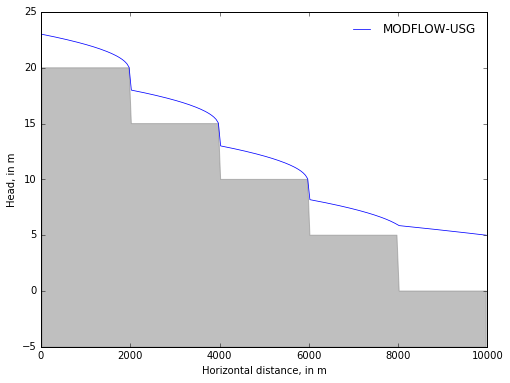

In [5]:
fig = plt.figure(figsize=(8,6))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
                    wspace=0.25, hspace=0.25)
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, mfusghead[0, 0, :], linewidth=0.75, color='blue', label='MODFLOW-USG')
ax.fill_between(x, y1=botm[1, 0, :], y2=-5, color='0.5', alpha=0.5)
leg = ax.legend(loc='upper right')
leg.draw_frame(False)
ax.set_xlabel('Horizontal distance, in m')
ax.set_ylabel('Head, in m')
ax.set_ylim(-5,25);